In [1]:
import pathlib #파일 위치찾기
import imageio
import numpy as np

#glob():glob 패턴을 사용하여 파일/디렉토리를 리스팅한다.
training_paths=pathlib.Path('./data/stage1_train/').glob('*/images/*.png')
training_sorted=sorted([x for x in training_paths])
im_path=training_sorted[45]
#imageio.imread(경로):해당 경로의 이미지를 배열로 가져온다.
im=imageio.imread(str(im_path))

#### 색감처리
이 데이터 세트의 영상은 획득되는 '양식(modality)'에 따라 RGB, RGBA 및 그레이 스케일 형식일 수 있습니다. 컬러 이미지의 경우 '채널'을 인코딩하는 세번째 차원이 있습니다. 이 첫번째 패스를 위해 sickit-image의 rgb2gray기능을 사용하여 모든 영상을 그레이 스케일로 강제 설정할 수 있습니다.


In [2]:
#rgb2gray 함수를 사용해서 컬러 이미지를 그레이 이미지로 변경
# Print the image dimensions
print('Original Image shape: {}'.format(im.shape))

# Coerce the image into grayscale format(if not already)
from skimage.color import rgb2gray

im_gray=rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original Image shape: (520, 696, 4)
New image shape: (520, 696)


<ipython-input-2-7759d88d8a73>:8: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im_gray=rgb2gray(im)


#### RGB to Gray

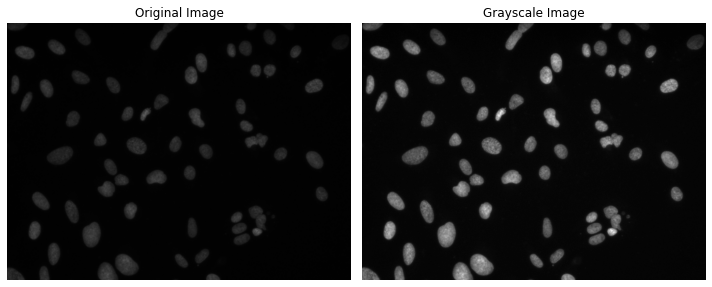

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray,cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

#### 배경 제거
- 배경제거를 위한 가장 간단한 접근법은 이미지에 관심 대상과 배경의 두가지 클래스가 있다고 가정하는 것입니다. 이러한 가정 하에, 우리는 데이터가 강도의 양분포에 속할 것으로 예상합니다. 최적의 분리 값을 찾으면 백그라운드 데이터를 "마스크"한 다음 남은 개체를 세기만 하면 됩니다.
- 임계값 찾는 방법: "Otsu"알고리즘 사용->bimodal distribution으로 모델링하고 최적의 분리값을 찾아 유용하기 때문이다.


#### Bimodal distribution(다봉분포 or 쌍봉분포)
- 서로 다른 두 개의 최빈값을 갖는 연속활률분포
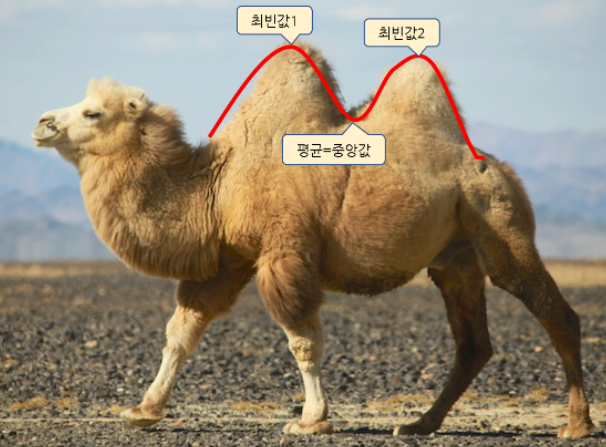

#### Otsu Algorithm(오츠의 알고리즘)
- 어떤 영상을 thresholing하고 싶을 때, 적정한 threshold 값을 찾아주는 알고리즘
- 방법: 경계값을 임의로 정해서 픽셀들을 두 부류로 나누고 두 부류의 명암 분포를 반복해서 구한 다음 두 부류의 명암 분포를 가장 균일하게 하는 경계 값을 선택한다. 즉, 특정 threshold를 T라 하면, T를 기준으로 이진 분류된 픽셀의 비율의 차가 가장 작은 optimal T를 구하는 것이다.
- 단점: 모든 threshold에 대해 계산해야 하기 때문에 속도가 느리다. 또한, 노이즈가 많은 영상에서 좋은 결과를 얻지 못하는 경우가 있다.

In [4]:
from skimage.filters import threshold_otsu
thresh_val=threshold_otsu(im_gray)
# np.where(배열에 대한 조건문, 참일때 값, 거짓일때 값)
mask=np.where(im_gray>thresh_val,1,0)

if np.sum(mask==0)<np.sum(mask==1):
    mask=np.where(mask,0,1)

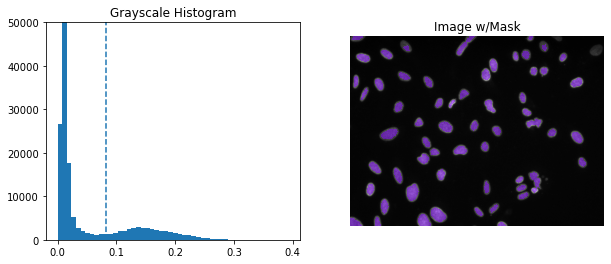

In [5]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels=im_gray.flatten()
plt.hist(im_pixels,bins=50)
#vlines(): 지정한 점을 따라 수직선을 표시
plt.vlines(thresh_val,0,100000,linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display=np.where(mask,mask,np.nan)
plt.imshow(im_gray,cmap='gray')
plt.imshow(mask_for_display,cmap='rainbow',alpha=0.5)
plt.axis('off')
plt.title('Image w/Mask')

plt.show()

#### 각 객체에 대한 마스크 도출

In [6]:
# scipy의 ndimage를 사용하여 이미지 프로세싱
from scipy import ndimage

#ndimage.label(mask):마스크에서 붙어있는 픽셀들을 하나의 물체로 생각하고 각각 라벨을 붙여준다.
#labels: 같은 셀이라면 같은 라벨로 표시
#nlabels:라벨 개수(라벨은 1-labels까지 존재한다. 0은 mask 없는 부분)
labels,nlabels=ndimage.label(mask)

label_arrays=[]
for label_num in range(1,nlabels+1):
    label_mask=np.where(labels==label_num,1,0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))
    

There are 76 separate components / objects detected.


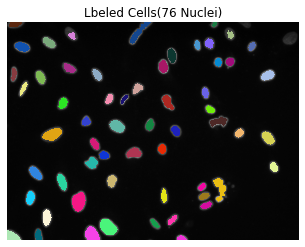

In [7]:
#Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap=ListedColormap(np.random.rand(256,3))

labels_for_display=np.where(labels>0,labels,np.nan)
plt.imshow(im_gray,cmap='gray')
plt.imshow(labels_for_display,cmap=rand_cmap)
plt.axis('off')
plt.title('Lbeled Cells({} Nuclei)'.format(nlabels))
plt.show()

#### 두가지 문제점 발생
- 독립 실행형 픽셀이 몇개 존재(ex. 오른쪽 상단)
- 일부 셀은 단일 마스크로 결합(ex. 상단-중간)
- 마스크에 반복하여 ndimage.find_objects를 사용하면,추가적인 처리 단계를 적용하는 것으로 발견된 각각의 핵을 확대가능하다.
- find.object는 이미지에서 레이블이 지정된 각 객체에 대한 좌표 범위 목록을 반환한다.

In [8]:
for label_ind,label_coords in enumerate(ndimage.find_objects(labels)):
    cell=im_gray[label_coords]
    #check if the label size is too small(픽셀의 개수가 10개 이하인 물체 제거)
    if np.product(cell.shape)<10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask=np.where(labels==label_ind+1,0,mask)
labels,nlabels=ndimage.label(mask)
print('There are now {} seperate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 seperate components / objects detected.


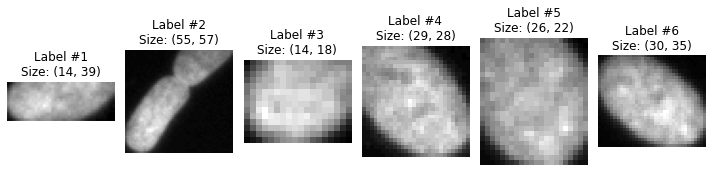

In [9]:
# 6종류의 물체 출력
fig,axes=plt.subplots(1,6,figsize=(10,6))

for ii,obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell=im_gray[obj_indices]
    axes[ii].imshow(cell,cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1,cell.shape))
plt.tight_layout()
plt.show()

In [10]:
# Get the object indices, and perform a binary opening procedure

two_cell_indices=ndimage.find_objects(labels)[1]
cell_mask=mask[two_cell_indices]
# label2에서 나타나는 문제(두 개의 물체를 하나의 물체로 인식)를 해결하기위해 binary_opening함수 사용 
# binary_opening(): 모서리를 점점 부드럽게 해주는 역할을 한다. 
# 여기에서는 이 점을 이용해서 붙어있는 두 출체의 경계를 만들어 준다.
cell_mask_opened=ndimage.binary_opening(cell_mask,iterations=8)

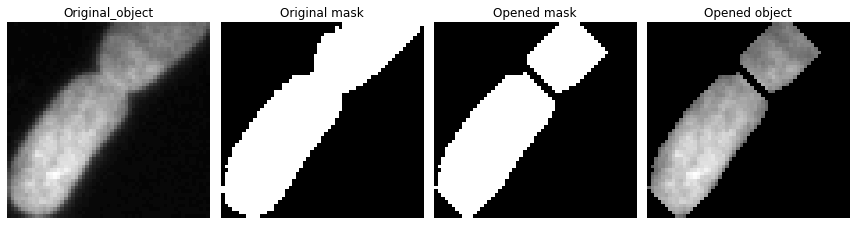

In [11]:
fig,axes=plt.subplots(1,4,figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices],cmap='gray')
axes[0].set_title('Original_object')
axes[1].imshow(mask[two_cell_indices],cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened,cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened,cmap='gray')
axes[3].set_title('Opened object')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

#### 레이블된 마스크 RLE 형태로 변환
- RLE(Run Length Encoding): 동일한 문자가 이어서 반복되는 경우 그것을 문자와 문자의 개수로 치환하는 방법

In [12]:
def rle_encoding(x):
    
    dots=np.where(x.T.flatten()==1)[0]
    run_lengths=[]
    prev=-2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1,0))
        run_lengths[-1]+=1
        prev=b
    return " ".join([str(i) for i in run_lengths])
print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


#### Combine it into a single function

In [13]:
import pandas as pd

def analyze_image(im_path):
    im_id=im_path.parts[-3]
    im=imageio.imread(str(im_path))
    im_gray=rgb2gray(im)
    
    thresh_val=threshold_otsu(im_gray)
    mask=np.where(im_gray>thresh_val,1,0)
    if np.sum(mask==0)<np.sum(mask==1):
        mask=np.where(mask,0,1)
        labels,nlabels=ndimage.label(mask)
    labels,nlabels=ndimage.label(mask)
    
    im_df=pd.DataFrame()
    for label_num in range(1,nlabels+1):
        label_mask=np.where(labels==label_num,1,0)
        if label_mask.flatten().sum()>10:
            rle=rle_encoding(label_mask)
            s=pd.Series({'ImageId':im_id,'EncodedPixels':rle})
            im_df=im_df.append(s,ignore_index=True)
    return im_df

def analyze_list_of_images(im_path_list):
    all_df=pd.DataFrame()
    for im_path in im_path_list:
        im_df=analyze_image(im_path)
        all_df=all_df.append(im_df,ignore_index=True)
        
    return all_df

In [14]:
testing=pathlib.Path('./data/stage1_test/').glob('*/images/*.png')
df=analyze_list_of_images(list(testing))
df.to_csv('submission.csv',index=None)

<ipython-input-13-3744a7ced004>:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im_gray=rgb2gray(im)
